In [2]:
using Plots, Splittings

In [3]:
pyplot()

Plots.PyPlotBackend()

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$





In [4]:
function vlasov_poisson(mesh::Mesh1D1V, f::Array{Float64,2}, 
        nstep, dt)
    
    nrj = Float64[]
    advection_x!( f, mesh, 0.5*dt)
    for istep in 1:nstep
        rho = compute_rho(mesh, f)
        e = compute_e(mesh, rho)
        advection_v!( f, mesh, e, dt)
        advection_x!( f, mesh, dt)
        push!(nrj, 0.5*log(sum(e.*e)*mesh.dx))
    end        
    nrj
    
end

vlasov_poisson (generic function with 1 method)

# Bump On Tail

In [8]:
α = 0.03
kx  = 0.3
xmin, xmax = 0.0, 2π / kx
nx, nv = 512, 512
vmin, vmax = -9., 9.
mesh = Mesh1D1V(xmin, xmax, nx, vmin, vmax, nv)
f = zeros(Float64,(mesh.nx,mesh.nv))           
for (i,x) in enumerate(mesh.x), (j,v) in enumerate(mesh.v)
     f[i,j]  = (1.0+α*cos(kx*x)) / (10*sqrt(2π)) * (9*exp(-0.5*v^2)+2*exp(-2*(v-4.5)^2))
end


In [9]:
nstep = 1000
t = range(0.0, stop=50.0, length=nstep)
dt = t[2]
@elapsed nrj = vlasov_poisson( mesh, f, nstep, dt)

21.73125063

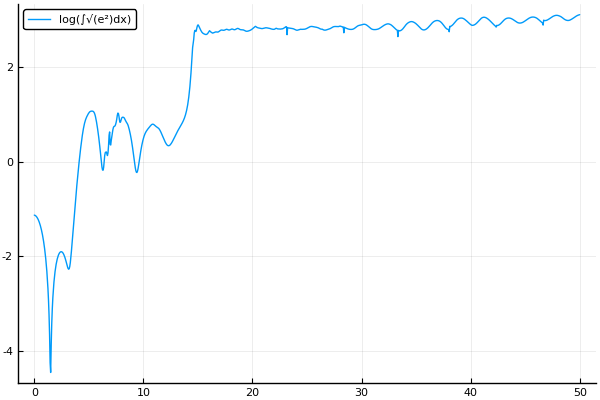

In [10]:
plot(t, nrj, label="log(∫√(e²)dx)")